In [16]:
import pandas as pd
from string import punctuation
import re
import numpy as np
from setup import *
import glob
import os
import pickle
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.callbacks import EarlyStopping

# Import the data and condense into one DataFrame
1. glob gets all of the files into a list
1. iterate through the list, load the df into a list of dfs
1. concatenate the list of dfs into single list
1. save the new DF in CSV for later use

In [2]:
file_list = glob.glob("Facebook Insights*")

df_list = []

for file in file_list:
    df_list.append(pd.read_csv(file,encoding='iso-8859-1').loc[1:])
    
# for df in df_list:
#     display(df)
    
df = pd.concat(df_list).reset_index()
df.to_csv('All_Files.csv')


In [3]:
df = pd.read_csv('All_Files.csv')
df = df[['Post Message', 'Type', 'Posted', 'Lifetime Post Total Reach','Lifetime Engaged Users']]
df.columns = ['Post', 'Type','Date','Reach','Engaged']

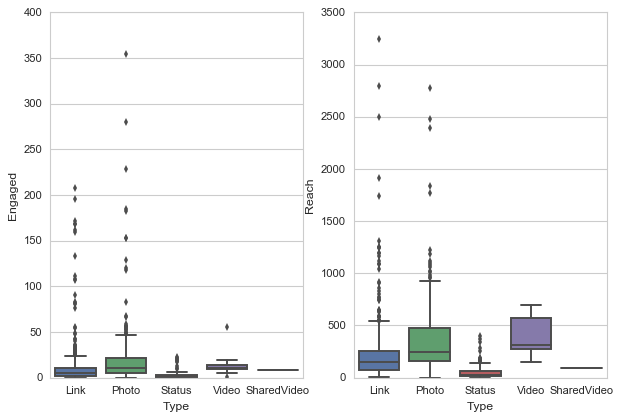

In [4]:
sns.set(style="whitegrid", color_codes=True)
f, (ax1, ax2) = plt.subplots(1,2)

sns.boxplot(x="Type", y="Engaged", data=df,  ax = ax1)
sns.boxplot(x="Type", y="Reach", data=df,  ax = ax2)
plt.show()


### Here we can see that the number for "outlying" good engagment in posts is around 25. Thus, should we decide to make the posts into categories (good, ok, bad) 30+ would be a good range for "good engagement".

In [5]:
df.columns

Index(['Post', 'Type', 'Date', 'Reach', 'Engaged'], dtype='object')

# Begin Preprocessing
1. Drop Na columns since they won't contribute, and will not tokenize
1. Tokenize The Sentences 
1. Map words to integers
1. Convert Posts to integer encoded vectors
1. Pad / trim vectors to be specific length

In [6]:
df.dropna(inplace=True)
ndf = pd.merge(df.groupby('Post')['Engaged'].apply(lambda p: max(p)).reset_index(),df[['Post', 'Type', 'Date', 'Reach', 'Engaged']], on = ['Post','Engaged'], how = 'inner')
ndf.drop_duplicates('Post',inplace=True)

In [7]:
display(ndf)

,Post,Engaged,Type,Date,Reach
0,"""An education is just another tool we can use ...",6,Status,8/9/16 5:03 PM,174
1,"""Despite his brilliance, Einstein couldn't sec...",5,Link,3/16/16 6:47 AM,227
2,"""Get off the grass!"" Check out some Tarleton ...",172,Link,2/11/16 10:05 AM,2796
3,"""Healers need healers!"" See what Dr. Merriman ...",4,Link,5/18/16 4:18 PM,150
4,"""I know who I am. I know what I?m capable of.""...",3,Link,2/8/16 9:17 AM,153
5,"""It does not matter how slowly you go as long ...",7,Photo,6/6/16 5:38 PM,243
6,"""My degree is the gateway to __."" Watch our n...",15,Link,7/18/16 5:41 AM,328
7,"""Tarleton College"" in 1899. https://www.facebo...",24,Photo,5/19/16 6:22 AM,426
8,"""Tell me about yourself."" How you will answer ...",1,Link,6/24/16 5:56 AM,30
9,"""The way to get started is to quit talking and...",10,Link,8/15/16 8:31 AM,185


In [8]:
fdf = ndf.loc[ndf['Reach']>=50].reset_index(drop=True)
display(fdf)
fdf['Prop'] = fdf['Engaged']/fdf['Reach']

,Post,Engaged,Type,Date,Reach
0,"""An education is just another tool we can use ...",6,Status,8/9/16 5:03 PM,174
1,"""Despite his brilliance, Einstein couldn't sec...",5,Link,3/16/16 6:47 AM,227
2,"""Get off the grass!"" Check out some Tarleton ...",172,Link,2/11/16 10:05 AM,2796
3,"""Healers need healers!"" See what Dr. Merriman ...",4,Link,5/18/16 4:18 PM,150
4,"""I know who I am. I know what I?m capable of.""...",3,Link,2/8/16 9:17 AM,153
5,"""It does not matter how slowly you go as long ...",7,Photo,6/6/16 5:38 PM,243
6,"""My degree is the gateway to __."" Watch our n...",15,Link,7/18/16 5:41 AM,328
7,"""Tarleton College"" in 1899. https://www.facebo...",24,Photo,5/19/16 6:22 AM,426
8,"""The way to get started is to quit talking and...",10,Link,8/15/16 8:31 AM,185
9,"""Then, in that hour of deliverance, my heart s...",13,Photo,5/29/17 6:01 AM,726


For large data sets, sorting the most common used words to the top provides faster integer encoding

In [9]:
counts = Counter()
fdf['Post'] = fdf['Post'].transform(lambda p : ' '.join([WordNetLemmatizer().lemmatize(x.lower()) for x in word_tokenize(p) if x.lower() not in stopwords.words('english') and x.lower() not in punctuation and 'http' not in x and x.isalpha()]))
for i,post in enumerate(fdf['Post']):
    text = [x for x in word_tokenize(post)]
    counts.update(text) 
# print(counts)
word_counts = sorted(counts,key=counts.get,reverse=True)
num_words = len(word_counts)
print('Number of words: ' + str(num_words))
# print(word_counts[:5])
word_to_int= {word: ii for ii, word in enumerate(word_counts,1)}
mapped_posts = []
for post in fdf['Post']:
    mapped_posts.append([word_to_int[word] for word in post.split()])

Number of words: 1720


In [10]:
with open('count_dict.txt', 'wb') as handle:
  pickle.dump(word_to_int, handle)

Get the max length to pad vectors. Here we could choose to trim vectors if necessary.

In [11]:
max_seq = 0

for i,x in enumerate(fdf['Post']):
#     print(x)
    if len(x.split()) >= max_seq:
        max_seq = len(x.split())
sequence_length = max_seq
proportion = fdf['Prop']
engagement = fdf['Engaged']
prop_eng = fdf[['Reach','Engaged']]
print(max_seq)

76


In [12]:
padded_sequences = sequence.pad_sequences(mapped_posts, maxlen = max_seq)

Make the test/train set. First we will train on all of the data to check the prediction on itself.

In [13]:
# X_train, X_test, y_train, y_test = padded_sequences, padded_sequences, proportion, proportion

In [126]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, proportion, test_size=0.20, random_state=42)
embedding_vector_length = 24
model = Sequential()
# model.add(Embedding(num_words+1, embedding_vector_length, input_length = max_seq))
# model.add(Conv1D(filters=16, kernel_size=4, padding='same', activation='relu'))
model.add(LSTM(64))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='relu'))
# earlystop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, verbose=1, mode='auto')
callbacks_list = []#earlystop]
model.compile(loss = 'mean_squared_error', optimizer='adam')
print(model.summary())
fit_model = model.fit(X_train,y_train, validation_data = (X_test,y_test), epochs = 100, batch_size=64, callbacks=callbacks_list)
scores = model.evaluate(X_test,y_test,verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_102 (Embedding)    (None, 76, 24)            41304     
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 76, 16)            1552      
_________________________________________________________________
lstm_104 (LSTM)              (None, 64)                20736     
_________________________________________________________________
dense_240 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_241 (Dense)            (None, 1)                 129       
Total params: 72,041
Trainable params: 72,041
Non-trainable params: 0
_________________________________________________________________
None
Train on 624 samples, validate on 157 samples
Epoch 1/100
624/624 [==============================] - 8s 13ms/step - loss: 0.0014 - va

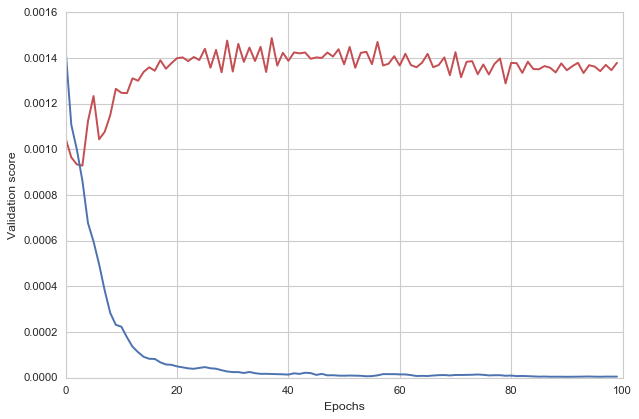

In [127]:
plt.plot(fit_model.history['val_loss'], 'r')
plt.plot(fit_model.history['loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

In [54]:
model_json = model.to_json()
with open("CCN.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CCN.h5")
print("Saved model to disk")

Saved model to disk
